In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
from collections import OrderedDict

In [2]:
# Class for color detection
class ColorLabeler:
    def __init__(self):
        # initialize the colors dictionary, containing the color
        # name as the key and the RGB tuple as the value
        colors = OrderedDict({
            "red": (255, 0, 0),
            "green": (0, 255, 0),
            "blue": (0, 0, 255)})

        # allocate memory for the L*a*b* image, then initialize
        # the color names list
        self.lab = np.zeros((len(colors), 1, 3), dtype="uint8")
        self.colorNames = []

        # loop over the colors dictionary
        for (i, (name, rgb)) in enumerate(colors.items()):
            # update the L*a*b* array and the color names list
            self.lab[i] = rgb
            self.colorNames.append(name)

        # convert the L*a*b* array from the RGB color space
        # to L*a*b*
        self.lab = cv2.cvtColor(self.lab, cv2.COLOR_RGB2LAB)

    def label(self, image, c):
        # construct a mask for the contour, then compute the
        # average L*a*b* value for the masked region
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        mask = cv2.erode(mask, None, iterations=2)
        mean = cv2.mean(image, mask=mask)[:3]

        # initialize the minimum distance found thus far
        minDist = (np.inf, None)

        # loop over the known L*a*b* color values
        for (i, row) in enumerate(self.lab):
            # compute the distance between the current L*a*b*
            # color value and the mean of the image
            d = dist.euclidean(row[0], mean)

            # if the distance is smaller than the current distance,
            # then update the bookkeeping variable
            if d < minDist[0]:
                minDist = (d, i)

        # return the name of the color with the smallest distance
        return self.colorNames[minDist[1]]

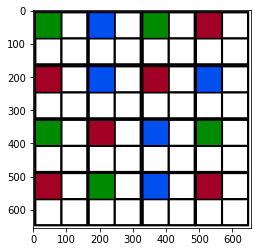

In [3]:
print_im = plt.imread("Top.jpg")
plt.imshow(print_im) 

In [4]:
BGR_image = cv2.imread("Top.jpg")
width = BGR_image.shape[0]
height = BGR_image.shape[1]
cl = ColorLabeler()

In [5]:
# function for segmentation of cubes
def mask(image):
    # mask of red  
    mask1 = cv2.inRange(image, (20, 0, 90), (45, 0, 200))

    # mask o green  
    mask2 = cv2.inRange(image, (0, 70, 0), (0, 170, 0))
    
    # mask o blue  
    mask3 = cv2.inRange(image, (155, 50, 0), (255, 120, 55))

    # final mask and masked
    mask = cv2.bitwise_or(mask1, mask2)
    total = cv2.bitwise_or(mask, mask3)

    target = cv2.bitwise_and(image,image, mask=total)
    
    return target

In [6]:
image = mask(BGR_image)

# gray image for masked image 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# lab image for masked image 
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

In [66]:
# function for final output
def info(gray_image):
    boxes = []
    # convert the grayscale image to binary image
    ret,thresh = cv2.threshold(gray_image,10,255,0)
    # find contours in the binary image
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        cX = 0
        cY = 0
        cZ = 0
        # calculate moments for each contour
        M = cv2.moments(c)
        if(abs(width - height) < 10):
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
        else:
            # calculate x,z coordinate of center
            cX = int(M["m10"] / M["m00"])
            cZ = int(M["m01"] / M["m00"])
        
        point = (cX, cY, cZ)
        col, row = location(point)
        
        color = cl.label(lab, c)
        box = (point , color , (col, row))
        boxes.append(box)
        
    boxes.sort()    
    return boxes

In [67]:
def location(point):
    col = int(np.floor(point[0] / 80) + 1)
    if(point[2] == 0):
        row = int(np.floor(point[1] / 80) + 1)
    else:
        row = int(np.floor(point[2] / 80) + 1)
    return col, row

In [68]:
#final data structure list of tuples
info(gray)

[((45, 46, 0), 'green', (1, 1)),
 ((45, 208, 0), 'red', (1, 3)),
 ((45, 369, 0), 'green', (1, 5)),
 ((45, 529, 0), 'red', (1, 7)),
 ((206, 46, 0), 'blue', (3, 1)),
 ((206, 208, 0), 'blue', (3, 3)),
 ((206, 369, 0), 'red', (3, 5)),
 ((206, 529, 0), 'green', (3, 7)),
 ((368, 46, 0), 'green', (5, 1)),
 ((368, 208, 0), 'red', (5, 3)),
 ((368, 369, 0), 'blue', (5, 5)),
 ((368, 529, 0), 'blue', (5, 7)),
 ((529, 46, 0), 'red', (7, 1)),
 ((529, 208, 0), 'blue', (7, 3)),
 ((529, 369, 0), 'green', (7, 5)),
 ((529, 529, 0), 'red', (7, 7))]